In [190]:
import numpy as np
import netCDF4 as nc
import auxiliary as au
import regression as reg
import datetime as dt
from matplotlib import pyplot as plt
from scipy import io
from scipy.interpolate import interp2d
import os
import sys
from scipy.interpolate import griddata
import h5py
import time
import random
import datetime
from bma_merge import bma


def divide_train_test(data, dividenum, randseed=-1):
    if randseed == -1:
        random.seed(time.time())
    num = len(data)
    subnum = int(num / dividenum)
    data_train = np.zeros([dividenum, num - subnum], dtype=int)
    data_test = np.zeros([dividenum, subnum], dtype=int)
    randindex = random.sample(range(num), num)
    for i in range(dividenum):
        data_test[i, :] = np.sort(data[randindex[i * subnum:(i + 1) * subnum]])
        data_train[i, :] = np.setdiff1d(data, data_test[i])
    return data_train, data_test


def double_cvindex(gmet_stndatafile, dividenum, rndseed=123):
    # index for double cross-validation
    datatemp = np.load(gmet_stndatafile)
    prcp_stn0 = datatemp['prcp_stn'][:, 0]
    tmean_stn0 = datatemp['tmean_stn'][:, 0]
    prcp_stnindex = np.argwhere(~np.isnan(prcp_stn0))
    prcp_stnindex = prcp_stnindex.flatten()
    tmean_stnindex = np.argwhere(~np.isnan(tmean_stn0))
    tmean_stnindex = tmean_stnindex.flatten()

    subnum1 = int(len(prcp_stnindex) / dividenum)
    subnum2 = int((len(prcp_stnindex) - subnum1) / dividenum)
    # prcp_testindex1 = np.zeros([dividenum,subnum1])
    # prcp_trainindex1 = np.zeros([dividenum,len(prcp_stnindex) - subnum1])
    prcp_trainindex1, prcp_testindex1 = divide_train_test(prcp_stnindex, dividenum, randseed=rndseed)
    prcp_testindex2 = np.zeros([dividenum, dividenum, subnum2], dtype=int)
    prcp_trainindex2 = np.zeros([dividenum, dividenum, len(prcp_stnindex) - subnum1 - subnum2], dtype=int)
    for i in range(dividenum):
        traini, testi = divide_train_test(prcp_trainindex1[i, :], dividenum, randseed=rndseed)
        prcp_trainindex2[i, :, :] = traini
        prcp_testindex2[i, :, :] = testi

    subnum1 = int(len(tmean_stnindex) / dividenum)
    subnum2 = int((len(tmean_stnindex) - subnum1) / dividenum)
    # tmean_testindex1 = np.zeros([dividenum,subnum1])
    # tmean_trainindex1 = np.zeros([dividenum,len(tmean_stnindex) - subnum1])
    tmean_trainindex1, tmean_testindex1 = divide_train_test(tmean_stnindex, dividenum, randseed=rndseed)
    tmean_testindex2 = np.zeros([dividenum, dividenum, subnum2], dtype=int)
    tmean_trainindex2 = np.zeros([dividenum, dividenum, len(tmean_stnindex) - subnum1 - subnum2], dtype=int)
    for i in range(dividenum):
        traini, testi = divide_train_test(tmean_trainindex1[i, :], dividenum, randseed=rndseed)
        tmean_trainindex2[i, :, :] = traini
        tmean_testindex2[i, :, :] = testi
    return prcp_trainindex1, prcp_testindex1, prcp_trainindex2, prcp_testindex2, \
           tmean_trainindex1, tmean_testindex1, tmean_trainindex2, tmean_testindex2


def calculate_anomaly(datatar, dataref, hwsize, amode, upbound=5, lowbound=0.2):
    # datatar, dataref: 2D [nstn, ntime]
    # amode: anomaly mode ('ratio' or 'diff')
    # hwsize: define time window (2*hwsize+1) used to calculate ratio (as ratio for a specific day is too variable)
    # upbound/lowbound: upper and lower limitation of ratio/difference
    if np.ndim(datatar) == 1:  # only one time step
        datatar = datatar[:, np.newaxis]
        dataref = dataref[:, np.newaxis]

    nstn, ntime = np.shape(datatar)
    if ntime < hwsize * 2 + 1:
        print('The window size is larger than time steps when calculating ratio between tar and ref datasets')
        print('Please set a smaller hwsize')
        sys.exit()

    anom = np.ones([nstn, ntime])

    for i in range(ntime):
        if i < hwsize:
            windex = np.arange(hwsize * 2 + 1)
        elif i >= ntime - hwsize:
            windex = np.arange(ntime - hwsize * 2 - 1, ntime)
        else:
            windex = np.arange(i - hwsize, i + hwsize + 1)
        dtari = np.nanmean(datatar[:, windex], axis=1)
        drefi = np.nanmean(dataref[:, windex], axis=1)

        if amode == 'ratio':
            temp = drefi / dtari
            temp[(dtari == 0) & (drefi == 0)] = 1
            anom[:, i] = temp
        elif amode == 'diff':
            anom[:, i] = drefi - dtari
        else:
            sys.exit('Unknow amode. Please use either ratio or diff')

    anom[anom > upbound] = upbound
    anom[anom < lowbound] = lowbound
    return anom


def extrapolation(datain, nearstn_loc, nearstn_dist):
    # datain: one or multiple time steps
    wexp = 3
    if np.ndim(datain) == 1:  # add time axis
        datain = datain[:, np.newaxis]

    if np.ndim(nearstn_loc) == 2:  # extrapolate to station points
        num = np.shape(nearstn_loc)[0]
        ntimes = np.shape(datain)[1]
        dataout = np.nan * np.zeros([num, ntimes], dtype=np.float32)
        for i in range(num):
            if not nearstn_loc[i, 0]>=0:
                continue
            nearloci = nearstn_loc[i, :]
            indloci = nearloci > -1
            dataini = datain[nearloci[indloci], :]
            disti = nearstn_dist[i, indloci]
            weighti = au.distanceweight(disti, np.max(disti) + 1, wexp)
            weighti[np.isnan(dataini[:,0])] = np.nan
            weighti = weighti / np.nansum(weighti)
            weighti2 = np.tile(weighti,[ntimes,1]).T
            dataout[i, :] = np.nansum(dataini * weighti2, axis=0)
    elif np.ndim(nearstn_loc) == 3:  # extrapolate to gridds
        nrows, ncols, nearnum = np.shape(nearstn_loc)
        nstn, ntimes = np.shape(datain)
        dataout = np.nan * np.zeros([nrows, ncols, ntimes], dtype=np.float32)
        for r in range(nrows):
            for c in range(ncols):
                if not nearstn_loc[r, c, 0]>=0:
                    continue
                nearloci = nearstn_loc[r, c, :]
                indloci = nearloci > -1
                dataini = datain[nearloci[indloci], :]
                disti = nearstn_dist[r, c, indloci]
                weighti = au.distanceweight(disti, np.max(disti) + 1, wexp)
                weighti[np.isnan(dataini[:,0])]=np.nan
                weighti = weighti / np.nansum(weighti)
                weighti2 = np.tile(weighti, [ntimes, 1]).T
                dataout[r, c, :] = np.nansum(dataini * weighti2, axis=0)
    else:
        print('The dimensions of tarlat or tarlon are larger than 2')
        sys.exit()
    if ntimes == 1:
        dataout = np.squeeze(dataout)
    return dataout


def findnearstn(stnlat, stnlon, tarlat, tarlon, nearnum, noself):
    # only use lat/lon to find near stations without considering distance in km
    # stnlat/stnlon: 1D
    # tarlat/tarlon: 1D or 2D
    # noself: 1--stnlat and tarlat have overlapped stations, which should be excluded from stnlat

    stnll = np.zeros([len(stnlat), 2])
    stnll[:, 0] = stnlat
    stnll[:, 1] = stnlon

    if len(np.shape(tarlat)) == 1:
        num = len(tarlat)
        nearstn_loc = -1 * np.ones([num, nearnum], dtype=int)
        nearstn_dist = -1 * np.ones([num, nearnum], dtype=float)
        for i in range(num):
            if np.isnan(tarlat[i]) or np.isnan(tarlon[i]):
                continue
            tari = np.array([tarlat[i], tarlon[i]])
            dist = au.distance(tari, stnll)
            dist[np.isnan(dist)] = 1000000000
            if noself == 1:
                dist[dist == 0] = np.inf  # may not be perfect, but work for SCDNA
            indi = np.argsort(dist)
            nearstn_loc[i, :] = indi[0:nearnum]
            nearstn_dist[i, :] = dist[nearstn_loc[i, :]]
    elif len(np.shape(tarlat)) == 2:
        nrows, ncols = np.shape(tarlat)
        nearstn_loc = -1 * np.ones([nrows, ncols, nearnum], dtype=int)
        nearstn_dist = -1 * np.ones([nrows, ncols, nearnum], dtype=float)
        for r in range(nrows):
            for c in range(ncols):
                if np.isnan(tarlat[r, c]) or np.isnan(tarlon[r, c]):
                    continue
                tari = np.array([tarlat[r, c], tarlon[r, c]])
                dist = au.distance(tari, stnll)
                dist[np.isnan(dist)] = 1000000000
                indi = np.argsort(dist)
                nearstn_loc[r, c, :] = indi[0:nearnum]
                nearstn_dist[r, c, :] = dist[nearstn_loc[r, c, :]]
    else:
        print('The dimensions of tarlat or tarlon are larger than 2')
        sys.exit()

    return nearstn_loc, nearstn_dist


def error_correction(dataori, anomaly, mode='ratio'):
    # default: time is the last dimension
    if mode == 'ratio':
        datacorr = dataori * anomaly
    elif mode == 'diff':
        datacorr = dataori + anomaly
    else:
        sys.exit('Wrong error correction mode')
    return datacorr


def calweight(obsall, preall, mode='RMSE', preprocess=True):
    nstn, ntime = np.shape(obsall)
    met = np.nan * np.zeros(nstn)
    for i in range(nstn):
        obs = obsall[i, :]
        pre = preall[i, :]
        if preprocess:
            # delete the nan values
            ind_nan = np.isnan(obs) | np.isnan(pre)
            obs = obs[~ind_nan]
            pre = pre[~ind_nan]

        if len(obs) < 3:
            continue

        if mode == 'RMSE':
            met[i] = np.sqrt(np.sum(np.square(obs - pre)) / len(obs))  # RMSE
        elif mode == 'CC':
            temp = np.corrcoef(obs, pre)
            met[i] = temp[0][1]  # CC
        else:
            sys.exit('Unknown inputs for calmetric')

    if mode == 'RMSE':
        met[met==0] = 0.01
        weight = 1 / (met ** 2)
    elif mode == 'CC':
        met[met < 0] = 0
        weight = met ** 2
    else:
        sys.exit('Unknown inputs for calmetric')

    return weight


def calmetric(dtar, dref, metname='RMSE'):
    if np.ndim(dtar) == 1:
        dtar = dtar[np.newaxis, :]
        dref = dref[np.newaxis, :]
    nstn, ntimes = np.shape(dtar)
    metout = np.nan * np.zeros(nstn, dtype=np.float32)
    if metname == 'RMSE':
        for i in range(nstn):
            metout[i] = np.sqrt(np.nansum(np.square(dtar[i, :] - dref[i, :])) / ntimes)  # RMSE
    elif metname == 'CC':
        for i in range(nstn):
            temp = np.corrcoef(dtar[i, :], dref[i, :])
            metout[i] = temp[0, 1]
    else:
        sys.exit('Unkown metric name')
    return metout


def ismember(a, b):
    # tf = np.in1d(a,b) # for newer versions of numpy
    tf = np.array([i in b for i in a])
    u = np.unique(a[tf])
    index = np.array([(np.where(b == i))[0][-1] if t else 0 for i, t in zip(a, tf)])
    return tf, index


def weightmerge(data, weight):
    if np.ndim(data) == 2:
        weight2 = weight.copy()
        weight2[np.isnan(data)] = np.nan
        dataout = np.nansum(data * weight2, axis=1) / np.nansum(weight2, axis=1)
    elif np.ndim(data) == 3:
        weight2 = weight.copy()
        weight2[np.isnan(data)] = np.nan
        dataout = np.nansum(data * weight2, axis=2) / np.nansum(weight2, axis=2)
        dataout[np.isnan(data[:,:,0])]=np.nan
    return dataout


def m_DateList(year_start, year_end, mode):
    # generate a date list (yyyymmdd) between start year and end year
    # mode: 'ByDay', 'ByMonth', 'ByYear': time scales of input files
    date_start = datetime.date(year_start, 1, 1)
    date_end = datetime.date(year_end, 12, 31)
    daynum = (date_end - date_start).days + 1

    # generate date in format: yyyymmdd
    date_ymd = np.zeros(daynum, dtype=int)
    dated = date_start
    for d in range(daynum):
        if d > 0:
            dated = dated + datetime.timedelta(days=1)
        date_ymd[d] = int(dated.strftime("%Y%m%d"))
    date_number = {'yyyymmdd': date_ymd,
                   'yyyymm': np.floor(date_ymd / 100).astype(int),
                   'yyyy': np.floor(date_ymd / 10000).astype(int),
                   'mm': np.floor(np.mod(date_ymd, 10000) / 100).astype(int),
                   'dd': np.mod(date_ymd, 100).astype(int)}

    # generate file list
    if mode == 'ByDay':
        datemode = date_number['yyyymmdd']
    else:
        if mode == 'ByMonth':
            datemode = date_number['yyyymm']
        elif mode == 'ByYear':
            datemode = date_number['yyyy']
        datemode = np.unique(datemode)

    date_list = [' '] * len(datemode)
    for i in range(len(datemode)):
        date_list[i] = str(datemode[i])

    return date_list, date_number

def box_cox_transform(data, exp=0.25):
    return (data ** exp - 1) / exp

def box_cox_recover(data, exp=0.25):
    dataout = (data * exp + 1) ** (1/exp)
    dataout[data < -1/exp] = 0
    return dataout

def merge_correction_stnerror(outpath, stnlle, stndata, readata_stn, taintestindex, nearstn_locl1, nearstn_distl1,
         nearstn_locl2, nearstn_distl2, dividenum, var, hwsize, corrmode, anombound, weightmode):
    # use 2-layer cross-validation to estimate the weight and independent data of merge/correction data
    # layer-1: aim to obtain correction and merged data at station points through cross-validation
    # layer-2: aim to obtain independent evaluation of correction data to support calculating merging weight in layer-1
    reanum, nstn, ntimes = np.shape(readata_stn)

    # initialization
    reacorr_stn = np.nan * np.zeros([reanum, nstn, ntimes], dtype=np.float32)  # corrected reanalysis data
    reamerge_weight_stn = np.nan * np.zeros([nstn, reanum])  # weight used to obtain reamerge_stn
    reamerge_stn = np.nan * np.zeros([nstn, ntimes], dtype=np.float32)  # merged reanalysis at station points

    for lay1 in range(dividenum):
        print('Correction/Merging at station points. Layer-1:', lay1)
        # extract train and test index for layer-1
        if var == 'trange':
            vari = 'tmean'  # trange and tmean have the same index
        else:
            vari = var
        trainindex1 = taintestindex[vari + '_trainindex1'][lay1, :]
        testindex1 = taintestindex[vari + '_testindex1'][lay1, :]
        stndata_trainl1 = stndata[trainindex1, :]
        stndata_testl1 = stndata[testindex1, :]
        stnlle_trainl1 = stnlle[trainindex1, :]
        stnlle_testl1 = stnlle[testindex1, :]

        # filename: save inputs for each layer-1
        file_reacorrl1 = outpath + '/' + var + '_layer_' + str(lay1 + 1) + '_' + weightmode + '.npz'
        if os.path.isfile(file_reacorrl1):
            datatemp = np.load(file_reacorrl1)
            weight_trainl1 = datatemp['reaweight']
            del datatemp
        else:

            # layer-2: start
            reacorr_trainl1 = np.zeros([reanum, len(trainindex1), ntimes], dtype=np.float32)
            weight_trainl1 = np.zeros([len(trainindex1), reanum], dtype=np.float32)

            for lay2 in range(dividenum):
                # print('Correction/Merging at station points. Layer-2:', lay2)
                # extract train and test index for layer-2 (subsets of trainindex1)
                trainindex2 = taintestindex[vari + '_trainindex2'][lay1, lay2, :]
                testindex2 = taintestindex[vari + '_testindex2'][lay1, lay2, :]
                stndata_trainl2 = stndata[trainindex2, :]
                stndata_testl2 = stndata[testindex2, :]
                stnlle_trainl2 = stnlle[trainindex2, :]
                stnlle_testl2 = stnlle[testindex2, :]

                for rr in range(reanum):
                    # print('Correction/Merging at station points. Reanalysis:', rr)
                    readata_trainl2 = readata_stn[rr, trainindex2, :]
                    readata_testl2 = readata_stn[rr, testindex2, :]

                    ### calculate corrected reanalysis data
                    # calculate anomaly at the train stations
                    anom_ori = calculate_anomaly(readata_trainl2, stndata_trainl2, hwsize, corrmode,
                                                 upbound=anombound[1], lowbound=anombound[0])
                    # extrapolate the ratio to the test stations
                    anom_ext = extrapolation(anom_ori, nearstn_locl2[lay1,lay2,:],nearstn_distl2[lay1,lay2,:])
                    # correct data at the test stations
                    readata_testl2_corr = error_correction(readata_testl2, anom_ext, mode=corrmode)
                    tf, index = ismember(testindex2, trainindex1)
                    reacorr_trainl1[rr, index, :] = readata_testl2_corr

            if weightmode == 'BMA':
                for i in range(len(trainindex1)):
                    dobs = stndata_trainl1[i, :]
                    drea = reacorr_trainl1[:, i, :].T
                    if var == 'prcp':
                        # exclude zero precipitation and carry out box-cox transformation
                        datatemp = np.zeros([ntimes,reanum+1])
                        datatemp[:,0] = dobs
                        datatemp[:,1:] = drea
                        ind0 = np.sum(datatemp>=0.01, axis=1) == (reanum+1) # positive hit events
                        if np.sum(ind0) < 10:
                            weight_trainl1[i, :] = np.ones(reanum)/reanum
                            continue
                        else:
                            dobs = box_cox_transform(dobs[ind0])
                            drea = box_cox_transform(drea[ind0,:])
                    w, sigma, sigma_s = bma(drea, dobs)
                    weight_trainl1[i, :] = w
            else:
                for rr in range(reanum):
                    weight_trainl1[:, rr] = calweight(stndata_trainl1, reacorr_trainl1[rr, :, :], weightmode)

            np.savez_compressed(file_reacorrl1, reacorr=reacorr_trainl1, stnlle=stnlle_trainl1,
                                reaweight=weight_trainl1)
            # layer-2: end


        # output: repeat error correction using train stations in layer-1 (as in layer-2 only 0.9*0.9=0.81 stations are used)
        # extrapolate from train stations to test stations
        for rr in range(reanum):
            readata_trainl1 = readata_stn[rr, trainindex1, :]
            readata_testl1 = readata_stn[rr, testindex1, :]
            anom_ori = calculate_anomaly(readata_trainl1, stndata_trainl1, hwsize, corrmode,
                                         upbound=anombound[1], lowbound=anombound[0])
            anom_ext = extrapolation(anom_ori, nearstn_locl1[lay1,:],nearstn_distl1[lay1,:])
            readata_testl1_corr = error_correction(readata_testl1, anom_ext, mode=corrmode)
            reacorr_stn[rr, testindex1, :] = readata_testl1_corr

        # output: extrapolate the weight from train stations to test stations (in layer-1)
        weight_testl1 = extrapolation(weight_trainl1, nearstn_locl1[lay1,:],nearstn_distl1[lay1,:])
        reamerge_weight_stn[testindex1, :] = weight_testl1

        # output: merge reanalysis products at the test stations
        nstn_testl1 = len(testindex1)
        mergedata_testl1 = np.nan * np.zeros([nstn_testl1, ntimes])
        for i in range(ntimes):
            datain = np.zeros([nstn_testl1, reanum], dtype=np.float32)
            for rr in range(reanum):
                datain[:, rr] = reacorr_stn[rr, testindex1, i]
            if var == 'prcp':
                datain = box_cox_transform(datain)
            dataout = weightmerge(datain, weight_testl1)
            if var == 'prcp':
                dataout = box_cox_recover(dataout)
            mergedata_testl1[:, i] = dataout
        reamerge_stn[testindex1, :] = mergedata_testl1

    weightsum = np.nansum(reamerge_weight_stn,axis=1)
    weightsum[weightsum==0] = np.nan
    for rr in range(reanum):
        reamerge_weight_stn[:, rr] = reamerge_weight_stn[:, rr] / weightsum
    return reamerge_stn, reamerge_weight_stn, reacorr_stn


def correct_merge(stndata, readata_raw, readata_stn, reacorr_stn, reamerge_stn, reamerge_weight_stn, neargrid_loc,
         neargrid_dist, merge_choice, mask, hwsize, corrmode, anombound, var, weightmode):

    nrows, ncols, nearnum = np.shape(neargrid_loc)
    reanum, nstn, nday = np.shape(readata_stn)

    neargrid_loc = neargrid_loc.copy()
    neargrid_dist = neargrid_dist.copy()
    mask2 = np.tile(mask[:,:,np.newaxis], (1,1,nearnum))
    neargrid_loc[mask2 != 1] = -1
    neargrid_dist[mask2 != 1] = np.nan
    del mask2


    # correct raw gridded reanalysis data using all stations
    corr_data = np.nan * np.zeros([reanum, nrows, ncols, nday], dtype=np.float32)
    for rr in range(reanum):
        # calculate correction ratio at all station point
        anom_ori = calculate_anomaly(readata_stn[rr, :, :], stndata[:, :],
                                     hwsize, corrmode, upbound=anombound[1], lowbound=anombound[0])
        anom_ext = extrapolation(anom_ori, neargrid_loc, neargrid_dist)
        corr_data[rr, :, :, :] = error_correction(readata_raw[rr,:,:,:], anom_ext, mode=corrmode)

    # first error estimation
    corr_error = np.nan * np.zeros([reanum, nrows, ncols, nday])
    for rr in range(reanum):
        corr_error[rr, :, :, :] = extrapolation(reacorr_stn[rr, :, :] - stndata, neargrid_loc, neargrid_dist)
    merge_error0 = extrapolation(reamerge_stn - stndata, neargrid_loc, neargrid_dist)

    if var == 'prcp' and weightmode == 'BMA':
        corr_data = box_cox_transform(corr_data)
        stndata = box_cox_transform(stndata)
        reamerge_stn = box_cox_transform(reamerge_stn)
        reacorr_stn = box_cox_transform(reacorr_stn)

        # correction error in normal space (box-cox)
        corr_error_bc = np.nan * np.zeros([reanum, nrows, ncols, nday])
        for rr in range(reanum):
            corr_error_bc[rr, :, :, :] = extrapolation(reacorr_stn[rr, :, :] - stndata, neargrid_loc, neargrid_dist)
        merge_error0_bc = extrapolation(reamerge_stn - stndata, neargrid_loc, neargrid_dist)

    # merge reanalysis data
    merge_data = np.nan * np.zeros([nrows, ncols, nday], dtype=np.float32)
    weight_grid = extrapolation(reamerge_weight_stn, neargrid_loc, neargrid_dist)
    for i in range(nday):
        datain = np.zeros([nrows, ncols, reanum])
        for rr in range(reanum):
            datain[:, :, rr] = corr_data[rr, :, :, i]
        merge_data[:, :, i] = weightmerge(datain, weight_grid)

    # calculate the error of merged data (this is actually independent with merged data estimation)
    merge_error = np.nan * np.zeros([nrows, ncols, nday], dtype=np.float32)
    for r in range(nrows):
        for c in range(ncols):
            if not np.isnan(mask[r, c]):
                chi = merge_choice[r, c]
                if chi > 0:
                    merge_error[r, c, :] = corr_error[chi - 1, r, c, :]
                else:
                    merge_error[r, c, :] = merge_error0[r, c, :]

    if var == 'prcp' and weightmode == 'BMA':
        merge_error_bc = np.nan * np.zeros([nrows, ncols, nday], dtype=np.float32)
        for r in range(nrows):
            for c in range(ncols):
                if not np.isnan(mask[r, c]):
                    chi = merge_choice[r, c]
                    if chi > 0:
                        merge_error_bc[r, c, :] = corr_error_bc[chi - 1, r, c, :]
                    else:
                        merge_error_bc[r, c, :] = merge_error0_bc[r, c, :]

    if var == 'prcp' and weightmode == 'BMA':
        merge_error_out = [''] * 2
        merge_error_out[0] = merge_error
        merge_error_out[1] = merge_error_bc
        merge_data = box_cox_recover(merge_data)
    else:
        merge_error_out = ['']
        merge_error_out[0] = merge_error
    return corr_data, corr_error, merge_data, merge_error_out

########################################################################################################################

# var = sys.argv[1]
# weightmode = sys.argv[2]

########################################################################################################################
var = 'prcp'  # ['prcp', 'tmean', 'trange']: this should be input from sbtach script
weightmode = 'RMSE'  # (CC, RMSE, BMA). Weight = CC**2, or Weight = 1/RMSE**2, or Weight = BMA
# basic settings
lontar = np.arange(-180 + 0.05, -50, 0.1)
lattar = np.arange(85 - 0.05, 5, -0.1)
hwsize = 0  # define time window (2*hwsize+1) used to calculate ratio (as ratio for a specific day is too variable)
nearnum = 8  # the number of nearby stations used to extrapolate points to grids (for correction and merging)
dividenum = 10  # divide the datasets into X parts, e.g. 10-fold cross-validation
anombound = [0.2, 5]  # upper and lower bound when calculating the anomaly for correction
year = [2000, 2000]  # year range for merging. note weight is calculated using all data not limited by year

# input files
# station list and data
# gmet_stnfile = '/home/gut428/GMET/eCAI_EMDNA/StnGridInfo/stnlist_whole.txt'
# gmet_stndatafile = '/home/gut428/stndata_whole.npz'
gmet_stnfile = '/Users/localuser/GMET/pyGMET_NA/stnlist_whole.txt'
gmet_stndatafile = '/Users/localuser/GMET/pyGMET_NA/stndata_whole.npz'  # to be saved. only process when absent

# mask file
# file_mask = '/datastore/GLOBALWATER/CommonData/EMDNA/DEM/NA_DEM_010deg_trim.mat'
file_mask = './DEM/NA_DEM_010deg_trim.mat'

# downscaled reanalysis: gridded data
prefix = ['ERA5_', 'MERRA2_', 'JRA55_']
# downscaled reanalysis data at station points
# path_readowngrid = ['/datastore/GLOBALWATER/CommonData/EMDNA/ERA5_day_ds',
#                    '/datastore/GLOBALWATER/CommonData/EMDNA/MERRA2_day_ds',
#                    '/datastore/GLOBALWATER/CommonData/EMDNA/JRA55_day_ds']
# file_readownstn = ['/datastore/GLOBALWATER/CommonData/EMDNA/ERA5_day_ds/ERA5_downto_stn.npz',
#                    '/datastore/GLOBALWATER/CommonData/EMDNA/MERRA2_day_ds/MERRA2_downto_stn.npz',
#                    '/datastore/GLOBALWATER/CommonData/EMDNA/JRA55_day_ds/JRA55_downto_stn.npz']
path_readowngrid = ['/Users/localuser/Research/Test',
                   '/Users/localuser/Research/Test',
                   '/Users/localuser/Research/Test']
file_readownstn = ['/Users/localuser/Research/Test/ERA5_downto_stn.npz',
                   '/Users/localuser/Research/Test/MERRA2_downto_stn.npz',
                   '/Users/localuser/Research/Test/JRA55_downto_stn.npz']

# output files
# train and test index file
ttindexfile = '/Users/localuser/Research/Test/2layer_train_test_index.npz'
# ttindexfile = '/datastore/GLOBALWATER/CommonData/EMDNA/ReanalysisCorrMerge/CrossValidate_2layer/2layer_train_test_index.npz'

# near stations
near_path = '/Users/localuser/Research/Test'
# near_path = '/home/gut428/ReanalysisCorrMerge'
near_file_GMET = '/Users/localuser/GMET/pyGMET_NA/weight_nearstn.npz'
# near_file_GMET = '/datastore/GLOBALWATER/CommonData/EMDNA/PyGMETout/weight.npz'
useGMET = False

# error and merging at station level
path_reastn_cv = '/Users/localuser/Research/Test'
# path_reastn_cv = '/datastore/GLOBALWATER/CommonData/EMDNA/ReanalysisCorrMerge/CrossValidate_2layer'
file_corrmerge_stn = path_reastn_cv + '/mergecorr_' + var + '_' + weightmode + '.npz'

# output corrected and merged data
path_reacorr = '/Users/localuser/Research/Test'
path_merge = '/Users/localuser/Research/Test'
# path_reacorr = '/home/gut428/ReanalysisCorrMerge/Reanalysis_corr'
# path_merge = '/home/gut428/ReanalysisCorrMerge/Reanalysis_merge'
file_mergechoice = path_merge + '/mergechoice_' + var + '_' +  weightmode + '.npz'

########################################################################################################################

# basic processing
print('start basic processing')
# decide correction mode according to variables
if var == 'prcp' or var == 'trange':
    corrmode = 'ratio'  # ratio or diff: mode for error correction
elif var == 'tmean':
    corrmode = 'diff'
else:
    sys.exit('Unknown correction mode')

if corrmode == 'diff':
    # default settings in this study since diff is for tmean and trange
    hwsize = 0
    anombound = [-999, 999]

# mask
mask = io.loadmat(file_mask)
mask = mask['DEM']
mask[~np.isnan(mask)] = 1  # 1: valid pixels
# attributes
reanum = len(file_readownstn)
nrows, ncols = np.shape(mask)
lontarm, lattarm = np.meshgrid(lontar, lattar)
lontarm[np.isnan(mask)] = np.nan
lattarm[np.isnan(mask)] = np.nan

# date
date_list, date_number = m_DateList(1979, 2018, 'ByYear')

# load observations for all stations
datatemp = np.load(gmet_stndatafile)
stndata = datatemp[var + '_stn']
stnlle = datatemp['stn_lle']
nstn, ntimes = np.shape(stndata)
del datatemp

########################################################################################################################

# design a two-layer cross-validation: generate station combinations
# index1 extracts 90% stations for merging and 10% stations for validation
# index2 divides the 90% from index1 into 90% and 10% again for error correction
if not os.path.isfile(ttindexfile):
    print('divide stations for 2-layer cross validation')
    prcp_trainindex1, prcp_testindex1, prcp_trainindex2, prcp_testindex2, \
    tmean_trainindex1, tmean_testindex1, tmean_trainindex2, tmean_testindex2 = \
        double_cvindex(gmet_stndatafile, dividenum, rndseed=123)
    np.savez_compressed(ttindexfile, prcp_trainindex1=prcp_trainindex1, prcp_testindex1=prcp_testindex1,
                        prcp_trainindex2=prcp_trainindex2, prcp_testindex2=prcp_testindex2,
                        tmean_trainindex1=tmean_trainindex1, tmean_testindex1=tmean_testindex1,
                        tmean_trainindex2=tmean_trainindex2, tmean_testindex2=tmean_testindex2)
    del prcp_trainindex1, prcp_testindex1, prcp_trainindex2, prcp_testindex2, \
        tmean_trainindex1, tmean_testindex1, tmean_trainindex2, tmean_testindex2

taintestindex = np.load(ttindexfile)

########################################################################################################################

# find near stations for all grids and station

if var == 'trange':
    vari = 'tmean'  # trange and tmean have the same index
else:
    vari = var

near_stnfile = near_path + '/near_stn_' + vari + '.npz'
near_gridfile = near_path + '/near_grid_' + vari + '.npz'

if os.path.isfile(near_stnfile):
    print('load near station information for points')
    with np.load(near_stnfile) as datatemp:
        nearstn_locl1 = datatemp['nearstn_locl1']
        nearstn_distl1 = datatemp['nearstn_distl1']
        nearstn_locl2 = datatemp['nearstn_locl2']
        nearstn_distl2 = datatemp['nearstn_distl2']
    del datatemp
else:
    print('find near stations for station points')
    # layer-1
    nstn_testl1 = np.shape(taintestindex[vari + '_testindex1'])[1]
    nearstn_locl1 = -1 * np.ones([dividenum, nstn_testl1, nearnum], dtype=int)
    nearstn_distl1 = -1 * np.ones([dividenum, nstn_testl1, nearnum], dtype=np.float32)
    for lay1 in range(dividenum):
        trainindex1 = taintestindex[vari + '_trainindex1'][lay1, :]
        testindex1 = taintestindex[vari + '_testindex1'][lay1, :]
        nearstn_locl1[lay1, :, :], nearstn_distl1[lay1, :, :] \
            = findnearstn(stnlle[trainindex1, 0], stnlle[trainindex1, 1],
                          stnlle[testindex1, 0], stnlle[testindex1, 1], nearnum, 0)
    # layer-2
    nstn_testl2 = np.shape(taintestindex[vari + '_testindex2'])[2]
    nearstn_locl2 = -1 * np.ones([dividenum, dividenum, nstn_testl2, nearnum], dtype=int)
    nearstn_distl2 = -1 * np.ones([dividenum, dividenum, nstn_testl2, nearnum], dtype=np.float32)
    for lay1 in range(dividenum):
        for lay2 in range(dividenum):
            trainindex2 = taintestindex[vari + '_trainindex2'][lay1, lay2, :]
            testindex2 = taintestindex[vari + '_testindex2'][lay1, lay2, :]
            nearstn_locl2[lay1, lay2, :, :], nearstn_distl2[lay1, lay2, :, :] \
                = findnearstn(stnlle[trainindex2, 0], stnlle[trainindex2, 1],
                              stnlle[testindex2, 0], stnlle[testindex2, 1], nearnum, 0)

    np.savez_compressed(near_stnfile, nearstn_locl1=nearstn_locl1, nearstn_distl1=nearstn_distl1,
                        nearstn_locl2=nearstn_locl2, nearstn_distl2=nearstn_distl2)

if os.path.isfile(near_gridfile):
    print('load near station information for grids')
    with np.load(near_gridfile) as datatemp:
        neargrid_loc = datatemp['neargrid_loc']
        neargrid_dist = datatemp['neargrid_dist']
else:
    print('find near stations for grids')
    stnlle_in = stnlle.copy()
    stnlle_in[np.isnan(stndata[:, 0]), 0:2] = np.nan
    neargrid_loc, neargrid_dist = findnearstn(stnlle_in[:, 0], stnlle_in[:, 1], lattarm, lontarm, nearnum, 0)
    np.savez_compressed(near_gridfile,neargrid_loc=neargrid_loc,neargrid_dist=neargrid_dist)

########################################################################################################################

# load downscaled reanalysis for all stations
print('load downscaled reanalysis data at station points')
readata_stn = np.nan * np.zeros([reanum, nstn, ntimes], dtype=np.float32)
for rr in range(reanum):
    dr = np.load(file_readownstn[rr])
    temp = dr[var + '_readown']
    if prefix[rr] == 'MERRA2_':  # unify the time length of all data as MERRA2 lacks 1979
        add = np.nan * np.zeros([nstn, 365])
        temp = np.concatenate((add, temp), axis=1)
    readata_stn[rr, :, :] = temp
    del dr, temp
if var == 'prcp':
    readata_stn[readata_stn<0] = 0

########################################################################################################################

# estimate the error of corrected and merged data at station points using cross-validation
# target outputs: weights for merging, merge choice, error of the merged dataset
# 0. load regression estimates and observations for all stations
# 1. select layer-1 stations (90% train, 10% test)
# 2. select layer-2 stations: 10 combinations (90% train, 10% test) from the 90% stations in layer-1
# 3. for all combinations in layer-2
# 3.1 perform error correction (1) at station points, (2) extrapolate to grids using training stations
# 3.2 perform evaluation using test stations
# 3.3 loop for all combinations and do evaluation at all stations (the 90% training stations from layer-1)
# 3.4 extrapolate evaluation accuracy indicators to the domain
# 4. merge three reanalysis using their indicators in 3.4
# 5. repeat 1-4 for all combinations in layer-1, and get accuracy indicators of the merged dataset for the domain
# 6. use indicators from 3.4 and 5, and select the best one among three reanalysis and merged datasets for each grid
# 7. get the final merged dataset and its accuracy indicators from steo-6

# get merged and corrected reanalysis data at all station points using two-layer cross-validation
if os.path.isfile(file_corrmerge_stn):
    print('load independent merged/corrected data at station points')
    datatemp = np.load(file_corrmerge_stn)
    reamerge_stn = datatemp['reamerge_stn']
    reamerge_weight_stn = datatemp['reamerge_weight_stn']
    reacorr_stn = datatemp['reacorr_stn']
    del datatemp
else:
    reamerge_stn = np.nan * np.zeros([nstn, ntimes], dtype=np.float32)
    reamerge_weight_stn = np.nan * np.zeros([12, nstn, reanum], dtype=np.float32)
    reacorr_stn = np.nan * np.zeros([reanum, nstn, ntimes], dtype=np.float32)
    # for each month
    for m in range(12):
        print('month', m+1)
        outpathm = path_reastn_cv + '/month_' + str(m + 1)
        if not os.path.isdir(outpathm):
            os.mkdir(outpathm)
        indm = date_number['mm'] == (m + 1)
        reamerge_stnm, reamerge_weight_stnm, reacorr_stnm = \
            merge_correction_stnerror(outpathm, stnlle, stndata[:,indm], readata_stn[:,:,indm], taintestindex,
                                      nearstn_locl1, nearstn_distl1, nearstn_locl2, nearstn_distl2,
                                      dividenum, var, hwsize, corrmode, anombound, weightmode)
        reamerge_stn[:, indm] = reamerge_stnm
        reacorr_stn[:, :, indm] = reacorr_stnm
        reamerge_weight_stn[m, :, :] = reamerge_weight_stnm
    # the variables are independent with their concurrent stations. thus, station data can be used to evaluate them
    np.savez_compressed(file_corrmerge_stn, reamerge_stn=reamerge_stn, reamerge_weight_stn=reamerge_weight_stn,
                        reacorr_stn=reacorr_stn, date_list=date_list)

########################################################################################################################

# which is the best for each grid (all reanalysis and the merged reanalysis)
if os.path.isfile(file_mergechoice):
    print('load merge choice file')
    datatemp = np.load(file_mergechoice)
    merge_choice = datatemp['merge_choice']
    del datatemp
else:
    print('determine the best data choice for each grid cell')
    merge_choice = -1 * np.zeros([12,nrows,ncols], dtype=int)
    for m in range(12):
        print('month', m+1)
        indm = date_number['mm'] == (m + 1)
        # evaluate merge and corrected reanalysis
        # this evaluation is feasible as merge or corrected data are all obtained using independent stations
        met_merge_stn = calmetric(reamerge_stn[:, indm], stndata[:, indm], metname='RMSE')
        met_corr_stn = np.nan * np.zeros([nstn, reanum])
        for rr in range(reanum):
            met_corr_stn[:, rr] = calmetric(reacorr_stn[rr][ :, indm], stndata[:, indm], metname='RMSE')

        metric_all = np.zeros([nrows, ncols, reanum + 1])
        met_merge_grid = extrapolation(met_merge_stn, neargrid_loc, neargrid_dist)
        met_corr_grid = extrapolation(met_corr_stn, neargrid_loc, neargrid_dist)
        metric_all[:, :, 0] = met_merge_grid
        metric_all[:, :, 1:] = met_corr_grid
        merge_choicem = np.argmax(metric_all, axis=2)  # 0: merge, 1 to N: corresponding corrected reanalysis
        merge_choicem[mask != 1] = -1
        merge_choice[m, :, :] = merge_choicem
        del metric_all, met_merge_grid, met_corr_grid
    np.savez_compressed(file_mergechoice, merge_choice=merge_choice)

########################################################################################################################

# final merging with data and error

# use the same weight with GMET estimation?
if useGMET == True:
    print('use near station information from GMET regression')
    del neargrid_loc, neargrid_dist
    datatemp = np.load(near_file_GMET)
    if var == 'prcp':
        neargrid_loc = datatemp['near_grid_prcpLoc']
        neargrid_dist = datatemp['near_grid_prcpDist']
    else:
        neargrid_loc = datatemp['near_grid_tempDist']
        neargrid_dist = datatemp['near_grid_tempDist']
    neargrid_loc = np.flipud(neargrid_loc)
    neargrid_dist = np.flipud(neargrid_dist)

# start ...
for y in range(year[0], year[1] + 1):
    print('Correction and Merge: year',y)
    filemerge = path_merge + 'mergedata_' + var + '_' + str(y) + weightmode + '.npz'
    filecorr = path_reacorr + 'reacorrdata_' + var + '_' + str(y) + '.npz'
    if os.path.isfile(filemerge) and os.path.isfile(filecorr):
        print('file exists ... continue')
        continue

    # initilization
    nday = np.sum(date_number['yyyy'] == y)
    corr_data = np.nan * np.zeros([reanum, nrows, ncols, nday], dtype=np.float32)
    corr_error = np.nan * np.zeros([reanum, nrows, ncols, nday], dtype=np.float32)
    merge_data = np.nan * np.zeros([nrows, ncols, nday], dtype=np.float32)
    merge_error = np.nan * np.zeros([nrows, ncols, nday], dtype=np.float32)
    if var == 'prcp' and weightmode == 'BMA':
        merge_error_bc = np.nan * np.zeros([nrows, ncols, nday], dtype=np.float32) # error in normal space (box-cox)

    # read raw gridded reanalysis data
    readata_raw = np.nan * np.zeros([reanum, nrows, ncols, nday], dtype=np.float32)
    for rr in range(reanum):
        if not (prefix[rr] == 'MERRA2_' and y == 1979):
            filer = path_readowngrid[rr] + '/' + prefix[rr] + var + '_' + str(y) + '.npz'
            d = np.load(filer)
            readata_raw[rr, :, :, :] = d['data']
            del d

    # process for each month
    for m in range(12):
        print('Correction and Merge: month', m+1)
        indym = (date_number['yyyy'] == y) & (date_number['mm'] == m+1)
        ym = date_number['mm'][date_number['yyyy'] == y]
        indm = ym == m+1

        corr_datam, corr_errorm, merge_datam, merge_errorm = \
            correct_merge(stndata[:, indym], readata_raw[:,:,:,indm], readata_stn[:, :, indym], reacorr_stn[:, :, indym],
                          reamerge_stn[:, indym], reamerge_weight_stn[m, :, :], neargrid_loc, neargrid_dist,
                          merge_choice[m, :, :], mask, hwsize, corrmode, anombound, var, weightmode)
        corr_data[:,:,:,indm] = corr_datam
        corr_error[:, :, :, indm] = corr_errorm
        merge_data[:, :, indm] = merge_datam
        merge_error[:, :, indm] = merge_errorm[0]
        if var == 'prcp' and weightmode == 'BMA':
            merge_error_bc[:, :, indm] = merge_errorm[1]

    np.savez_compressed(filecorr, corr_data=corr_data, corr_error=corr_error,
                        reaname=prefix, latitude=lattar, longitude=lontar)
    if var == 'prcp' and weightmode == 'BMA':
        np.savez_compressed(filemerge, merge_data=merge_data, merge_error=merge_error, merge_error_bc=merge_error_bc,
                            latitude=lattar, longitude=lontar, reaname=prefix)
    else:
        np.savez_compressed(filemerge, merge_data=merge_data, merge_error=merge_error,
                            latitude=lattar, longitude=lontar, reaname=prefix)


start basic processing
load near station information for points
load near station information for grids
load downscaled reanalysis data at station points


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:741: RuntimeWarning: invalid value encountered in less


load independent merged/corrected data at station points
load merge choice file
Correction and Merge: year 2000
Correction and Merge: month 1


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:95: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:106: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:107: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:284: RuntimeWarning: invalid value encountered in true_divide


Correction and Merge: month 2


KeyboardInterrupt: 

In [191]:
useGMET=True
if useGMET == True:
    print('use near station information from GMET regression')
    del neargrid_loc, neargrid_dist
    datatemp = np.load(near_file_GMET)
    if var == 'prcp':
        neargrid_loc = datatemp['near_grid_prcpLoc']
        neargrid_dist = datatemp['near_grid_prcpDist']
    else:
        neargrid_loc = datatemp['near_grid_tempDist']
        neargrid_dist = datatemp['near_grid_tempDist']
    neargrid_loc = np.flipud(neargrid_loc)
    neargrid_dist = np.flipud(neargrid_dist)

# start ...
for y in range(year[0], year[1] + 1):
    print('Correction and Merge: year',y)
    filemerge = path_merge + 'mergedata_' + var + '_' + str(y) + weightmode + '.npz'
    filecorr = path_reacorr + 'reacorrdata_' + var + '_' + str(y) + '.npz'
    if os.path.isfile(filemerge) and os.path.isfile(filecorr):
        print('file exists ... continue')
        continue

    # initilization
    nday = np.sum(date_number['yyyy'] == y)
    corr_data = np.nan * np.zeros([reanum, nrows, ncols, nday], dtype=np.float32)
    corr_error = np.nan * np.zeros([reanum, nrows, ncols, nday], dtype=np.float32)
    merge_data = np.nan * np.zeros([nrows, ncols, nday], dtype=np.float32)
    merge_error = np.nan * np.zeros([nrows, ncols, nday], dtype=np.float32)
    if var == 'prcp' and weightmode == 'BMA':
        merge_error_bc = np.nan * np.zeros([nrows, ncols, nday], dtype=np.float32) # error in normal space (box-cox)

    # read raw gridded reanalysis data
    readata_raw = np.nan * np.zeros([reanum, nrows, ncols, nday], dtype=np.float32)
    for rr in range(reanum):
        if not (prefix[rr] == 'MERRA2_' and y == 1979):
            filer = path_readowngrid[rr] + '/' + prefix[rr] + var + '_' + str(y) + '.npz'
            d = np.load(filer)
            readata_raw[rr, :, :, :] = d['data']
            del d

    # process for each month
    for m in range(12):
        print('Correction and Merge: month', m+1)
        indym = (date_number['yyyy'] == y) & (date_number['mm'] == m+1)
        ym = date_number['mm'][date_number['yyyy'] == y]
        indm = ym == m+1

        corr_datam, corr_errorm, merge_datam, merge_errorm = \
            correct_merge(stndata[:, indym], readata_raw[:,:,:,indm], readata_stn[:, :, indym], reacorr_stn[:, :, indym],
                          reamerge_stn[:, indym], reamerge_weight_stn[m, :, :], neargrid_loc, neargrid_dist,
                          merge_choice[m, :, :], mask, hwsize, corrmode, anombound, var, weightmode)
        corr_data[:,:,:,indm] = corr_datam
        corr_error[:, :, :, indm] = corr_errorm
        merge_data[:, :, indm] = merge_datam
        merge_error[:, :, indm] = merge_errorm[0]
        if var == 'prcp' and weightmode == 'BMA':
            merge_error_bc[:, :, indm] = merge_errorm[1]

    np.savez_compressed(filecorr, corr_data=corr_data, corr_error=corr_error,
                        reaname=prefix, latitude=lattar, longitude=lontar)
    if var == 'prcp' and weightmode == 'BMA':
        np.savez_compressed(filemerge, merge_data=merge_data, merge_error=merge_error, merge_error_bc=merge_error_bc,
                            latitude=lattar, longitude=lontar, reaname=prefix)
    else:
        np.savez_compressed(filemerge, merge_data=merge_data, merge_error=merge_error,
                            latitude=lattar, longitude=lontar, reaname=prefix)


use near station information from GMET regression
Correction and Merge: year 2000
Correction and Merge: month 1


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:95: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:106: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:107: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:284: RuntimeWarning: invalid value encountered in true_divide


Correction and Merge: month 2


KeyboardInterrupt: 

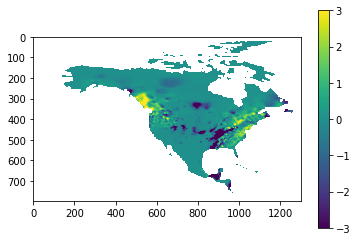

In [205]:
plt.imshow(merge_error[:,:,3])
plt.colorbar()
plt.clim([-3,3])

In [210]:
def cov(a, b):

    if len(a) != len(b):
        return

    a_mean = np.mean(a)
    b_mean = np.mean(b)

    sum = 0

    for i in range(0, len(a)):
        sum += ((a[i] - a_mean) * (b[i] - b_mean))

    return sum/(len(a)-1)

a=np.arange(5)
b=np.array([4,2,1,2,3])
print(cov(a,b))
print(np.cov((a,b,a)))

-0.5
[[ 2.5 -0.5  2.5]
 [-0.5  1.3 -0.5]
 [ 2.5 -0.5  2.5]]


array([[1.0000000e+00, 0.0000000e+00],
       [8.8817842e-16, 1.0000000e+00]])